# Salt stress downregulates AhrC

In [3]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy
import matplotlib.pyplot as plt

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)
from ecolime.util.helper_functions import *
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(ecolime.__file__)

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/ecolime/__init__.py


Load

In [161]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()
base_mu = bsub.solution.f

M- model response

In [163]:
bsub = cobra.io.load_json_model(ijo_directory)
## Add sodium entrance through osmosis due to high concentrations
na1_c = bsub.metabolites.na1_c
rxn = cobra.Reaction(id='EX_na1_c_osm')
rxn.add_metabolites({
    na1_c:1.0
})
bsub.add_reaction(rxn)

In [111]:
# Sodium rates and simulation
na_rates = np.arange(0,5,0.1)
flux_dict = dict()
for rate in na_rates:
    bsub.reactions.get_by_id('EX_na1_c_osm').lower_bound = rate
    bsub.reactions.get_by_id('EX_na1_c_osm').upper_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

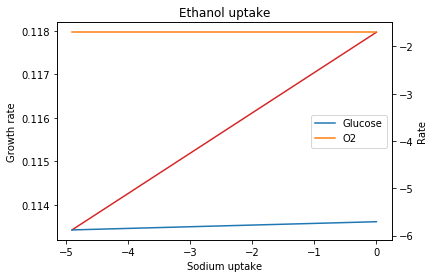

In [112]:
fig,ax1 = plt.subplots()
plt.title('Sodium uptake')

ax1.plot(-flux_responses.loc['EX_na1_c_osm'],flux_responses.loc['BIOMASS_BS_10'],
            label = 'growth',color='tab:red')
ax1.set_xlabel('Sodium uptake')
ax1.set_ylabel('Growth rate')

ax2 = ax1.twinx()
ax2.plot(-flux_responses.loc['EX_na1_c_osm'],flux_responses.loc['EX_o2_e'],
            label = 'Glucose')
ax2.plot(-flux_responses.loc['EX_na1_c_osm'],flux_responses.loc['EX_glc__D_e'],
            label = 'O2')
ax2.set_ylabel('Rate')

ax2.legend()

M-model predicts an increase in growth rate at increased sodium uptake

In [157]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)

In [158]:
flux_responses = pd.DataFrame.from_dict(flux_dict)

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:7 RuntimeWarning: invalid value encountered in true_divide


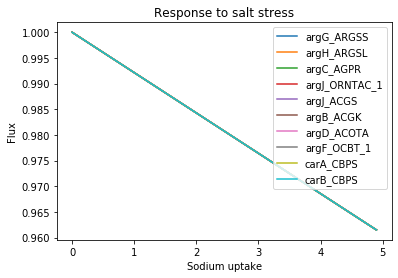

In [159]:
import pandas as pd
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF', 'carA', 'carB']
for idx,gene in enumerate(gene_dictionary.loc[genes]['locus_id'].values):
    rxns = bsub.genes.get_by_id(gene).reactions
    for rxn in rxns:
        flux_profile = abs(flux_responses.loc[rxn.id].values)
        flux_profile /= max(flux_profile)
        plt.plot(na_rates,flux_profile,label=genes[idx]+'_'+rxn.id)
plt.title('Response to salt stress')
plt.xlabel('Sodium uptake')
plt.ylabel('Flux')
plt.legend()

Is it an artifact of growth rate increase?

In [164]:
bsub.reactions.get_by_id('EX_glc__D_e').lower_bound = -10
bsub.reactions.get_by_id('BIOMASS_BS_10').lower_bound = base_mu
bsub.reactions.get_by_id('BIOMASS_BS_10').upper_bound = base_mu

bsub.objective = 'EX_glc__D_e'
bsub.reactions.get_by_id('EX_glc__D_e').objective_coefficient = -1.

# Sodium rates and simulation
na_rates = np.arange(0,5,0.1)
flux_dict = dict()
for rate in na_rates:
    bsub.reactions.get_by_id('EX_na1_c_osm').lower_bound = rate
    bsub.reactions.get_by_id('EX_na1_c_osm').upper_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:6 RuntimeWarning: invalid value encountered in true_divide


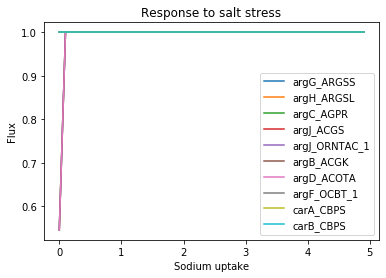

In [165]:
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF', 'carA', 'carB']
for idx,gene in enumerate(gene_dictionary.loc[genes]['locus_id'].values):
    rxns = bsub.genes.get_by_id(gene).reactions
    for rxn in rxns:
        flux_profile = abs(flux_responses.loc[rxn.id].values)
        flux_profile /= max(flux_profile)
        plt.plot(na_rates,flux_profile,label=genes[idx]+'_'+rxn.id)
plt.title('Response to salt stress')
plt.xlabel('Sodium uptake')
plt.ylabel('Flux')
plt.legend()

M-model is not able to capture the decrease in AhrC regulon

## ME-model simulations

In [184]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [185]:
new_mu = me.solution.f

Add sodium uptake through osmosis

In [186]:
rxn = cobrame.MEReaction(id='EX_na1_c_osm')
me.add_reaction(rxn)
rxn.reaction = ' -> na1_c'

In [194]:
def single_flux_response(me,rate,mu_fix=False):
    me.reactions.get_by_id('EX_na1_c_osm').lower_bound = rate
    me.reactions.get_by_id('EX_na1_c_osm').upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [198]:
# Calculation at several sodium uptake rates
all_rxns = [rxn.id for rxn in me.reactions]
na_rates = -np.arange(0,5,0.5)
flux_dict = dict()
print('Rates to use: {}'.format(na_rates))

import multiprocessing as mp
NP = min([len(na_rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in na_rates:
    pool.apply_async(single_flux_response, args=(me,rate,new_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()

Rates to use: [-0.  -0.5 -1.  -1.5 -2.  -2.5 -3.  -3.5 -4.  -4.5]
Calculating with 10 cores


,-4.5,-4.0,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,-0.0
biomass_dilution,0.101786,0.101786,0.101786,0.101786,0.101786,0.101786,0.101786,0.101786,0.101786,0.101786
protein_biomass_to_biomass,0.035773,0.035780,0.035804,0.035806,0.035771,0.035774,0.035677,0.035648,0.035803,0.035801
mRNA_biomass_to_biomass,0.000120,0.000120,0.000119,0.000119,0.000120,0.000119,0.000120,0.000120,0.000119,0.000118
tRNA_biomass_to_biomass,0.000718,0.000718,0.000716,0.000716,0.000719,0.000719,0.000730,0.000729,0.000720,0.000719
rRNA_biomass_to_biomass,0.005244,0.005240,0.005213,0.005210,0.005242,0.005239,0.005275,0.005255,0.005205,0.005198


In [199]:
# Save results
flux_responses_me.to_csv('salt_flux_responses.csv',index_label='rxn_id')

In [218]:
flux_responses_me = pd.read_csv('salt_flux_responses.csv',index_col=0)

Text(0.5, 0, 'Sodium uptake')

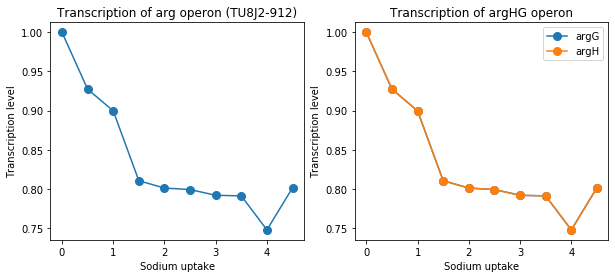

In [235]:
# Visualize transcription profiles
plt.figure(figsize=(10,4))

# TU8J2-912 operon: argCJBDF-carAB
plt.subplot(1,2,1)
expression = flux_responses_me.loc['transcription_TU8J2_912_from_BSU25200-MONOMER']
plt.plot(-flux_responses_me.loc['EX_na1_c_osm'],
         expression/max(expression),
         marker = 'o',markersize=8)
plt.title('Transcription of arg operon (TU8J2-912)')
plt.ylabel('Transcription level')
plt.xlabel('Sodium uptake')

# argHG transcription
plt.subplot(1,2,2)
expression = flux_responses_me.loc['transcription_TU_BSU29450']
plt.plot(-flux_responses_me.loc['EX_na1_c_osm'],
         expression/max(expression), label='argG',
         marker = 'o',markersize=8)
expression = flux_responses_me.loc['transcription_TU_BSU29440']
plt.plot(-flux_responses_me.loc['EX_na1_c_osm'],
         expression/max(expression), label='argH',
         marker = 'o',markersize=8)
plt.legend()
plt.title('Transcription of argHG operon')
plt.ylabel('Transcription level')
plt.xlabel('Sodium uptake')

Text(0.5, 1.0, 'artPQR')

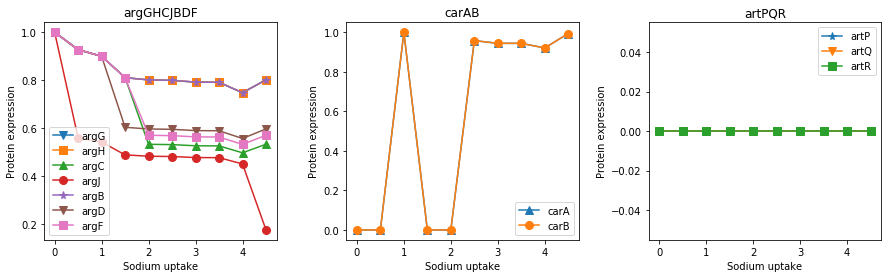

In [250]:
# Visualize protein expression profiles
plt.figure(figsize=(15,4))
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 

flux_responses_me[abs(flux_responses_me)<1e-16] = 0

plt.subplots_adjust(wspace=0.3)
plt.subplot(1,3,1)
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_na1_c_osm'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('argGHCJBDF')

plt.subplot(1,3,2)
genes = ['carA', 'carB']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_na1_c_osm'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('carAB')

plt.subplot(1,3,3)
genes = ['artP', 'artQ','artR']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    plt.plot(-flux_responses_me.loc['EX_na1_c_osm'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('artPQR')

# artPQR are not included in the model

Notes:
* Sodium diffuses through channels via _facilitated_ passive transport. These results were calculated by an "spontaneous" uptake of sodium into the cytosol so as to emulate this increase in uptake due to high concentrations, without it being a consequence of increased expression of transporters.